<a href="https://colab.research.google.com/github/wzrd13/SpamBert/blob/main/spam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Εξόρυξη Δεδομένων και Αλγόριθμοι Μάθησης**
## Ερώτημα 2

Βασίλειος Χαράλαμπος Αυγερινός ΑΜ: 1054298 \\
Λούκας Πανδής ΑΜ: 1059683


Στο παρών ερώτημα για την κατηγοριοποίηση των email σε spam και not spam επιλέξαμε να κάνουμε fine tune ένα προ-εκπαιδευμένο language model και συγκεκριμένα το [Bert](https://en.wikipedia.org/wiki/BERT_(language_model)) small της google. Το συγκεκριμένο μοντέλο είναι ένα bidirectional transformer δίκτυο που στο πρώτο επίπεδο έχει προ-εκπαιδευμένα word embeddings όπως ζητάει η άσκηση. Στο τέλος του δικτύου προστέθηκε ένα linear output layer με διαστάσεις (512, 2) για τον διαχωρισμό της εισόδου σε spam και not spam. Για το fine tuning το δίκτυο εκπαιδευτικέ με batch size 32 για 4 epochs πετυχαίνοντας accuracy 99.14 %. Ο κώδικας υλοποιήθηκε σε pytorch με περιστασιακή χρήση τον βιβλιοθηκών numpy pandas και transformers. 


Για την αξιολόγηση του ερωτήματος προτείνετε ο κώδικας να ελεγχθεί στο google colab καθώς το κατέβασμα του μοντέλου σε σύνδεση με χαμηλό bandwidth μπορεί να πάρει λίγη ώρα (για να τρέξει ο κώδικας αρκεί να γίνει upload του dataset στο ακολουθώ path "/content/spam_or_not_spam.csv")

**Σημειώνετε** ότι το μοντέλο δεν περιέχετε στα παραδοτέα λόγο του μεγάλου μεγέθους του. 


### Εξαρτήσεις κώδικα

In [ ]:
# Dependencies
!pip install tqdm boto3 requests regex sentencepiece sacremoses
!pip install transformers
!pip install pandas torch numpy

In [ ]:
# Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModel, BertForSequenceClassification
from transformers import AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check for gpu
device = torch.device("cpu")
if torch.cuda.is_available():     
    device = torch.device("cuda")
    print(device)  

cuda


### Επεξεργασία των δεδομένων

In [ ]:
# Load spam dataset from memory
spam_dt = pd.read_csv('/content/spam_or_not_spam.csv', sep=",")

# Drop rows with Nan values
spam_dt.dropna(inplace=True)

# Display some information about the dataset
print(f"number of samples: {len(spam_dt)}")
print(f"max sample size: {spam_dt.email.str.count(' ').max()}")
print(f"min sample size: {spam_dt.email.str.count(' ').min()}")
print(f"average sample size: {spam_dt.email.str.count(' ').mean()}")

# The maximum input size of pretrained transformer models is usually 512 tokens 
cond = spam_dt.email.str.count(' ') > 512
print(f"number of samples with size > 512: {spam_dt.email[cond].count()}")

Λόγο του ότι το Bert έχει μέγιστη είσοδο 512 χαρακτήρες έγινε αφαίρεση των email που ξεπερνάνε αυτό το όριο από το dataset (συνολικά 91 emails από τα 1500.

In [ ]:
# Remove samples with more than 512 words
cond = spam_dt.email.str.count(' ') + 1 > 512
spam_dt = spam_dt[~cond]
print(f"number of samples after removal: {len(spam_dt)}")

number of samples after removal: 1407


In [ ]:
# Download/load bert tokenizer
tokenizer = AutoTokenizer.from_pretrained("google/bert_uncased_L-4_H-512_A-8", do_lower_case=True)

#### Tokenization

In [ ]:
tokenized_emails = []
attention_masks = []

for email in spam_dt.email.values:
    
    encoded_dict = tokenizer.encode_plus(
                        email,
                        truncation=True,
                        add_special_tokens = True, 
                        max_length = 512,          
                        padding='max_length',
                        return_attention_mask = True,
                        return_tensors = 'pt',     
                    )
    
    # Add the encoded sentence to the list.    
    tokenized_emails.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

#### Διαχωρισμός του dataset σε train test (75-25)

In [ ]:
# Create a 75-25 train-validation split.
from sklearn.model_selection import train_test_split
labels = spam_dt.label.values

# Split dataset with sk learn
X_train_ids, X_test_ids,\
X_train_masks, X_test_masks,\
y_train, y_test = train_test_split(
                        tokenized_emails, 
                        attention_masks, 
                        labels, 
                        test_size=0.25, 
                        random_state=42
                    )

# Create Pytorch datasets for train and test
train_dt = TensorDataset(
    torch.cat(X_train_ids), 
    torch.cat(X_train_masks), 
    torch.tensor(y_train)
)

test_dt = TensorDataset(
    torch.cat(X_test_ids), 
    torch.cat(X_test_masks), 
    torch.tensor(y_test)
)

print(f'training samples: {len(train_dt)}')
print(f'validation samples: {len(test_dt)}')

training samples: 1055
validation samples: 352


In [ ]:
# Create DataLoaders
batch_size = 32

# Train select batches randomly
train_dl = DataLoader(
            train_dt,
            sampler = RandomSampler(train_dt),
            batch_size = batch_size
        )

# Test pull out batches sequentially.
validation_dl = DataLoader(
            test_dt,
            sampler = SequentialSampler(test_dt),
            batch_size = batch_size
        )

### Αρχικοποίηση του μοντέλου και του optimizer

In [ ]:
# Load pretrained bert-base-uncased with a linear layer for classification on top
model = BertForSequenceClassification.from_pretrained(
    "google/bert_uncased_L-4_H-512_A-8",
    num_labels = 2, # Number of labels (spam->0, not_spam->1)
    output_attentions = True,
    output_hidden_states = False,
)

# Run model to device
model.to(device);

In [ ]:
# Recomended configuration of Optimizer and Learning Rate Scheduler for fine-tuning the bert model
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# 1 to 2 epochs should be enough
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_dl) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

### Εκπαίδευση του δικτύου

In [ ]:
def accuracy(preds, labels):
    '''
    Takes predictions and labels and returns accuracy (max 1)
    '''
    prediction = np.argmax(preds, axis=1).flatten()
    labels = labels.flatten()
    return np.sum(prediction == labels) / len(labels)

#### Training loop

In [ ]:
import random
import numpy as np
from tqdm.notebook import trange, tqdm

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Stats for training and validating
training_stats = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ########################################
    #               Training
    # ########################################

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in tqdm(enumerate(train_dl), total=len(train_dl)):

        # Load tensors to device
        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)

        model.zero_grad()        
        
        # Forward pass
        sc_output = model(input_ids, 
                             token_type_ids=None, 
                             attention_mask=input_mask, 
                             labels=labels)
        
        loss = sc_output['loss']
        logits = sc_output['logits']

        # Accumulate loss
        total_train_loss += loss.item()

        # Backward pass
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters
        optimizer.step()

        # Update learning rate
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dl)            

    print("")
    print(f"  Average training loss: {avg_train_loss}")
        
    # ########################################
    #               Validation
    # ########################################

    print("")
    print("Running Validation...")

    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in tqdm(validation_dl):
        
        # Load tensors to device
        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)
        
        with torch.no_grad():        
            
            sc_output = model(input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=input_mask,
                                   labels=labels)

            loss = sc_output['loss']
            logits = sc_output['logits']
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        c_label_ids = labels.to('cpu').numpy()

        # Calculate accuracy
        total_eval_accuracy += accuracy(logits, c_label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dl)
    print(f"  Accuracy: {avg_val_accuracy}")

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dl)
    
    print(f"  Validation Loss: {avg_val_loss}")
    print(f"  Validation took: {validation_time}")

    # Save stats for the epoch
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

PATH = f"/content/spam_clasification_bert_epochs-{epochs}"
torch.save(model.state_dict(), PATH)

#### f1-score, precision, recall

In [ ]:
    # ########################################
    #               f1-score
    # ########################################

from sklearn.metrics import classification_report, accuracy_score
# score(y_true, y_pred)

# Load trained model
model = BertForSequenceClassification.from_pretrained(
    "google/bert_uncased_L-4_H-512_A-8",
    num_labels = 2, # Number of labels (spam->0, not_spam->1)
    output_attentions = True,
    output_hidden_states = False,
)


PATH = f"/content/spam_clasification_bert_epochs-4"
model.load_state_dict(torch.load(PATH, map_location=torch.device(device)))
model.to(device)
model.eval();

predictions = []
labels_p = []

for batch in validation_dl:
       
    # Load tensors to device
    input_ids = batch[0].to(device)
    input_mask = batch[1].to(device)
    labels = batch[2].to(device)

    labels_p.append(labels)

    with torch.no_grad():        
        
        sc_output = model(input_ids, 
                                token_type_ids=None, 
                                attention_mask=input_mask,
                                labels=labels)

        predictions.append(sc_output['logits'])

predictions = torch.cat(predictions)
predictions = np.argmax(predictions.to('cpu'), axis=1).flatten()
labels = torch.cat(labels_p).flatten().to('cpu')

# print(score(predictions, labels))

In [ ]:
print(classification_report(labels,predictions))
print(accuracy_score(labels, predictions))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       233
           1       0.99      0.98      0.99       119

    accuracy                           0.99       352
   macro avg       0.99      0.99      0.99       352
weighted avg       0.99      0.99      0.99       352

0.9914772727272727


### Οπτικοποίηση των attention layers

Για την οπτικοποίηση των attention layers απαιτητέ επιπλέων η εγκατάσταση των παρακάτω πακέτων.

In [ ]:
!pip install seaborn
!pip isntall matplotlib

In [ ]:
import seaborn as sns; sns.set_theme()
import io
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [ ]:
def get_attentions(attentions, layer=0, attention_head=0, avg=False):
  '''
  get the particular output for a particular layer and attention head
  layer -> 0 to 7
  attention_head -> 0 to 3
  '''
  if avg:
    #avg over all attention heads in a layer
    return attentions[layer].squeeze(0).mean(dim=0)

  #return values for a particular attention head inside a specific layer
  return attentions[layer].squeeze(0)[attention_head]

def plt_attentions(mat, labs, fig_size=(10,10)):
  fig, ax = plt.subplots(figsize=fig_size) 
  ax = sns.heatmap(
      mat.detach().cpu().numpy(), 
      annot=False, 
      yticklabels=labs,
      xticklabels=labs, 
      cmap=sns.light_palette("blue")
  )
  ax.xaxis.set_ticks_position('top')
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
  if title:
    ax.set_title(title)

In [ ]:
# ########################################
#               visualization
# ########################################

# Load trained model
model = BertForSequenceClassification.from_pretrained(
    "google/bert_uncased_L-4_H-512_A-8",
    num_labels = 2, # Number of labels (spam->0, not_spam->1)
    output_attentions = True,
    output_hidden_states = False,
)

PATH = f"/content/spam_clasification_bert_epochs-4"
model.load_state_dict(torch.load(PATH))
model.to(device)
model.eval();

label = 0


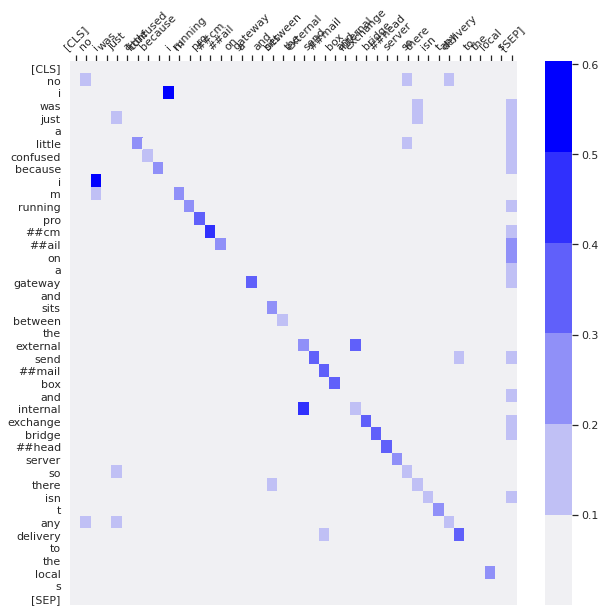

In [ ]:
# Load an email to feed to the network
email = spam_dt.email[1][:200]

# Encode email without pading
encoded_email = tokenizer.encode_plus(
    email,
    truncation=True,
    add_special_tokens = True, 
    max_length = 512,          
    return_attention_mask = True,
    return_tensors = 'pt',     
)

# Pass email to the model
model.eval()
sc_output = model(
    encoded_email['input_ids'].to(device)
)

print(f"label = {np.argmax(sc_output['logits'].detach().cpu())}")

tokens = tokenizer.convert_ids_to_tokens(encoded_email['input_ids'][0])
attention = sc_output['attentions']

# Plot attentions for specified layer and attention head
plt_attentions(get_attentions(attention, layer=0, attention_head=1), tokens)